# Section 3.2 — Confidence intervals

This notebook contains the code examples from [Section 3.2 Confidence intervals]() of the **No Bullshit Guide to Statistics**. Use the "rocket" icon at the top-right to make the code cells interactive (Live Code), or run this notebook an ephemeral JupyterLab cloud instance (Binder).

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot helper functions
from plot_helpers import plot_pdf
from plot_helpers import savefigure

In [3]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
RCPARAMS.update({'figure.figsize': (10, 3)})   # good for screen
# RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# Useful colors
# snspal = sns.color_palette()
# blue, orange, purple = snspal[0], snspal[1], snspal[4]

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/stats/confidence_intervals"

<Figure size 640x480 with 0 Axes>

In [4]:
# set random seed for repeatability
np.random.seed(42)

In [5]:
#######################################################

$\def\stderr#1{\mathbf{se}_{#1}}$
$\def\stderrhat#1{\hat{\mathbf{se}}_{#1}}$
$\newcommand{\Mean}{\textbf{Mean}}$
$\newcommand{\Var}{\textbf{Var}}$
$\newcommand{\Std}{\textbf{Std}}$
$\newcommand{\Freq}{\textbf{Freq}}$
$\newcommand{\RelFreq}{\textbf{RelFreq}}$
$\newcommand{\DMeans}{\textbf{DMeans}}$
$\newcommand{\Prop}{\textbf{Prop}}$
$\newcommand{\DProps}{\textbf{DProps}}$

$$
\newcommand{\CI}[1]{\textbf{CI}_{#1}}
\newcommand{\CIL}[1]{\textbf{L}_{#1}}
\newcommand{\CIU}[1]{\textbf{U}_{#1}}
\newcommand{\ci}[1]{\textbf{ci}_{#1}}
\newcommand{\cil}[1]{\textbf{l}_{#1}}
\newcommand{\ciu}[1]{\textbf{u}_{#1}}
$$


(this cell contains the macro definitions like $\stderr{\overline{\mathbf{x}}}$, $\stderrhat{}$, $\Mean$, ...)

## Definitions



### Review of estimators

Recall all the estimators (functions that take samples as inputs) we defined in the previous section.

In [6]:
def mean(sample):
    return sum(sample) / len(sample)

def var(sample):
    xbar = mean(sample)
    sumsqdevs = sum([(xi-xbar)**2 for xi in sample])
    return sumsqdevs / (len(sample)-1)

def std(sample):
    s2 = var(sample)
    return np.sqrt(s2)

def dmeans(xsample, ysample):
    dhat = mean(xsample) - mean(ysample)
    return dhat

### Interpreting confidence intervals

Saved figure to figures/stats/confidence_intervals/confidence_intervals_mean_rvX_n20.pdf
Saved figure to figures/stats/confidence_intervals/confidence_intervals_mean_rvX_n20.png


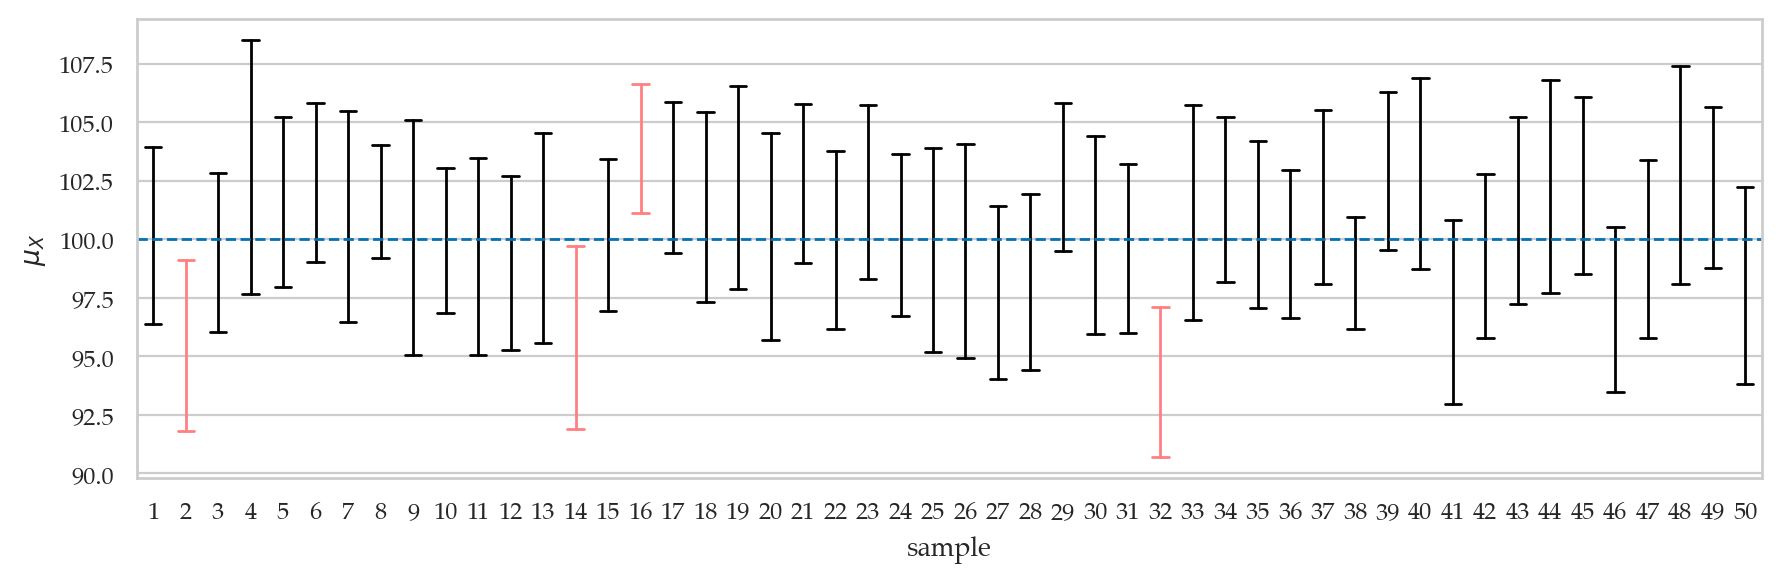

In [7]:
# FIGURES ONLY
filename = os.path.join(DESTDIR, "confidence_intervals_mean_rvX_n20.pdf")

from scipy.stats import norm
from plot_helpers import gen_samples
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
palette = sns.color_palette(palette=["#ff8080", "#000000"])

N = 50
n = 20

rvX = norm(100,10)

# Generate N=50 samples of size n=20 from a normal dist
np.random.seed(47)
samples_df = gen_samples(rvX, n=n, N=N)
samples_df.columns = range(1,N+1)
df2 = samples_df.melt(var_name="sample", value_name="n")

def confint(data):
    """
    Compute 90% confidence interval.
    Note:  1.729 = tdist(19).ppf(0.95)
    """
    n = len(data)
    mean = data.mean()
    std = data.std(ddof=1)
    se = std / np.sqrt(n)
    return [mean - 1.729*se, mean + 1.729*se]

# Add new column to indicate if CI contains mean or not
for sidx in range(1,N+1):
    sample = df2[df2["sample"]==sidx]["n"].values
    C_L, C_U = confint(sample)
    if C_L <= rvX.mean() and rvX.mean() <= C_U:
        outcome = 1  # includes population mean
    else:
        outcome = 0  # doesn't include population mean
    df2.loc[df2["sample"]==sidx,"success"] = outcome


with warnings.catch_warnings(), plt.rc_context({"figure.figsize":(9,3)}):
    warnings.filterwarnings('ignore', category=UserWarning)    
    ax = sns.pointplot(x="sample", y="n", hue="success", data=df2,
                       errorbar=confint, palette=palette,
                       join=False, capsize=0.5, markers=" ", errwidth=1)
    ax.set_ylabel("$\mu_X$") # "$\overline{\mathbf{x}}$"
    ax.axhline(y=rvX.mean(), color='b', label='Mean', linestyle='--', linewidth=1)
    ax.legend([],[], frameon=False)
    savefigure(ax, filename)

## Confidence interval constructions

Ingredients:

- knowledge of the sampling distribution $\widehat{\Theta}$ of the estimator
- knowledge of the inverse cumulative distribution function (inverse-CDF)
  of the sampling distributions $F^{-1}_{\widehat{\Theta}}$


Procedure:

- calculate the $\tfrac{\alpha}{2}$-quantile, 
  $F^{-1}_{\widehat{\Theta}}(\tfrac{\alpha}{2})$,
  and the $(1-\tfrac{\alpha}{2})$-quantile,
  $F^{-1}_{\widehat{\Theta}}(1-\tfrac{\alpha}{2})$
  of the sampling distribution
- use a pivotal quantity to convert the quantiles of the sampling distribution
  and obtain the lower bound and upper bounds of the confidence interval


Recall the two methods for approximating sampling distributions:
analytical approximation formulas (based on probability distributions)
and the bootstrap estimation procedure (based on computation),
which we learned in [Section 3.1](./31_estimators.ipynb).
We'll now learn how to compute confidence intervals based on these approximation methods.

### Bootstrap confidence intervals

In [8]:
np.random.seed(42)
xsample = [1,2,3,4,5]
mean(xsample)

3.0

In [9]:
from stats_helpers import gen_boot_dist
xbars_boot = gen_boot_dist(xsample, estfunc=mean,B=100)
xbars_boot[0:5]  # first five bootstrap means

[4.4, 3.2, 3.6, 3.2, 2.6]

In [10]:
[np.percentile(xbars_boot,5),
 np.percentile(xbars_boot,95)]

[1.8, 4.2]

In [11]:
[np.quantile(xbars_boot,0.05),
 np.quantile(xbars_boot,0.95)]

[1.8, 4.2]

### Analytical approximations

$$
    z_\ell = F_{Z}^{-1}(\tfrac{\alpha}{2})
    \qquad \text{and} \qquad
    z_u = F_{Z}^{-1}(1-\tfrac{\alpha}{2}).
$$

In [12]:
from scipy.stats import norm

rvZ = norm(loc=0, scale=1)
rvZ.ppf(0.95)

1.6448536269514722

In [13]:
rvZ = norm(0, 1)
rvZ.ppf(0.95)

1.6448536269514722

#### Default parameters

In [14]:
rvZ = norm()
rvZ.ppf(0.95)

1.6448536269514722

#### Class methods

In [15]:
norm.ppf(0.95, loc=0, scale=1)

1.6448536269514722

In [16]:
norm.ppf(0.95)

1.6448536269514722

#### Construct 90% confidence interval distribution

In [17]:
alpha = 0.1
z_l = norm.ppf(alpha/2)
z_u = norm.ppf(1-alpha/2)
[z_l, z_u]

[-1.6448536269514729, 1.6448536269514722]

#### Other reference distributions

In [18]:
from scipy.stats import t as tdist
tdist.ppf(0.95, df=6)

1.9431802803927816

#### 95th percentile of the chi-square distribution

In [19]:
from scipy.stats import chi2
chi2.ppf(0.95, df=6)

12.591587243743977

## Confidence interval for the population mean

$$
    T = \frac{\overline{\mathbf{X}} - \mu_X}{ \stderrhat{\overline{\mathbf{x}}} }
    \sim \mathcal{T}(n-1).
$$

To build a $(1-\alpha)$ confidence interval,
we first calculate the $\frac{\alpha}{2}$ and $(1-\frac{\alpha}{2})$ quantiles of Student's $t$-distribution:

$$
    t_\ell = F_{T}^{-1}(\tfrac{\alpha}{2})
    \qquad \text{and} \qquad
    t_u = F_{T}^{-1}(1-\tfrac{\alpha}{2}).
$$

### Example 1: confidence interval for the mean apple weight

In [20]:
apples = pd.read_csv("../datasets/apples.csv")
asample = apples["weight"]
asample.values

array([205., 182., 192., 189., 217., 192., 210., 240., 225., 191., 193.,
       209., 167., 183., 210., 198., 239., 188., 179., 182., 200., 197.,
       245., 192., 201., 218., 198., 211., 208., 217.])

#### Analytical confidence interval for the mean

In [21]:
n = asample.count()
abar = mean(asample)
asehat = std(asample) / np.sqrt(n)
n,   abar,  asehat

(30, 202.6, 3.3959407817427336)

In [22]:
from scipy.stats import t as tdist
rvT = tdist(n-1)
t_05 = rvT.ppf(0.05)
t_95 = rvT.ppf(0.95)
[abar + t_05*asehat, abar + t_95*asehat]

[196.82986523723363, 208.37013476276636]

#### Bootstrap confidence interval for the mean

In [23]:
np.random.seed(50)
abars_boot = gen_boot_dist(asample, estfunc=mean)
[np.percentile(abars_boot,5),
 np.percentile(abars_boot,95)]

[197.23333333333332, 208.26666666666668]

### Reusable procedure

In [24]:
def ci_mean(sample, alpha=0.1, method="a"):
    """
    Compute the confidence interval for the population mean.
    """
    assert method in ["a", "b"]
    if method == "a":        # analytical approximation
        n = len(sample)
        xbar = np.mean(sample)
        sehat = np.std(sample, ddof=1) / np.sqrt(n)
        t_l = tdist.ppf(alpha/2, df=n-1)
        t_u = tdist.ppf(1-alpha/2, df=n-1)
        return [xbar + t_l*sehat, xbar + t_u*sehat]
    elif method == "b":          # bootstrap estimation
        xbars_boot = gen_boot_dist(sample, estfunc=mean)
        return [np.quantile(xbars_boot, alpha/2),
                np.quantile(xbars_boot, 1-alpha/2)]

# ALT.
# from stats_helpers import ci_mean

### Verify coverage probability

In [25]:
np.random.seed(42)

N = 100  # change to N=1000 for more accuracty
n = 20

from scipy.stats import norm
muK = 1000
sigmaK = 10
rvK = norm(muK, sigmaK)

acount, bcount = 0, 0
for j in range(0, N):
    ksample = rvK.rvs(n)
    cia = ci_mean(ksample, alpha=0.1, method="a")
    if cia[0] <= muK <= cia[1]:
        acount += 1
    cib = ci_mean(ksample, alpha=0.1, method="b")
    if cib[0] <= muK <= cib[1]:
        bcount += 1

print("Coverage proportion of analytical approx. CIs:", acount/N)
print("Coverage proportion of bootstrap CIs:", bcount/N)

Coverage proportion of analytical approx. CIs: 0.89
Coverage proportion of bootstrap CIs: 0.86


## Confidence interval for the population variance

### Example 2: confidence interval for the variance of apple weights

In [26]:
apples = pd.read_csv("../datasets/apples.csv")
asample = apples["weight"]
n = asample.count()
s2 = var(asample)
n,   s2

(30, 345.9724137931035)

In [27]:
from scipy.stats import chi2
rvX2 = chi2(n-1)
q_05 = rvX2.ppf(0.05)
q_95 = rvX2.ppf(0.95)
[(n-1)*s2/q_95, (n-1)*s2/q_05]

[235.7592779198888, 566.5796548600426]

#### Bootstrap confidence interval for the variance

In [28]:
np.random.seed(53)
avars_boot = gen_boot_dist(asample, estfunc=var)
[np.percentile(avars_boot,5),
 np.percentile(avars_boot,95)]

[196.387816091954, 480.82183908046]

### Reusable procedure

In [29]:
def ci_var(sample, alpha=0.1, method="a"):
    """
    Compute the confidence interval for the population variance.
    """
    assert method in ["a", "b"]
    if method == "a":        # analytical approximation
        n = len(sample)
        s2 = np.var(sample, ddof=1)
        q_l = chi2.ppf(alpha/2, df=n-1)
        q_u = chi2.ppf(1-alpha/2, df=n-1)
        return [(n-1)*s2/q_u, (n-1)*s2/q_l]
    elif method == "b":          # bootstrap estimation
        vars_boot = gen_boot_dist(sample, estfunc=var)
        return [np.quantile(vars_boot, alpha/2),
                np.quantile(vars_boot, 1-alpha/2)]

# ALT.
# from stats_helpers import ci_var

### Verify coverage probability

In [30]:
np.random.seed(42)

N = 100  # change to N=1000 for more accuracty
n = 20

from scipy.stats import norm
muK = 1000
sigmaK = 10
rvK = norm(muK, sigmaK)

acount, bcount = 0, 0
for j in range(0, N):
    ksample = rvK.rvs(n)
    cia = ci_var(ksample, alpha=0.1, method="a")
    if cia[0] <= sigmaK**2 <= cia[1]:
        acount += 1
    cib = ci_var(ksample, alpha=0.1, method="b")
    if cib[0] <= sigmaK**2 <= cib[1]:
        bcount += 1

print("Coverage proportion of analytical approx. CIs:", acount/N)
print("Coverage proportion of bootstrap CIs:", bcount/N)

Coverage proportion of analytical approx. CIs: 0.89
Coverage proportion of bootstrap CIs: 0.81


## Confidence interval for the difference between means

### Example 3: confidence interval for difference in electricity prices

In [31]:
eprices = pd.read_csv("../datasets/eprices.csv")
pricesW = eprices[eprices["end"]=="West"]["price"]
pricesE = eprices[eprices["end"]=="East"]["price"]

In [32]:
# sample size and std in West and East
stdW, nW = pricesW.std(), pricesW.count()
stdE, nE = pricesE.std(), pricesE.count()
stdW, nW, stdE, nE

(1.5621388471508475, 9, 0.8776547030454391, 9)

In [33]:
# center of the CI
dhat = dmeans(pricesW, pricesE)
dhat

3.0

In [34]:
# standard error
seD = np.sqrt(stdW**2/nW + stdE**2/nE)
seD

0.5972674401486562

In [35]:
# degrees of freedom
from stats_helpers import calcdf
df = calcdf(stdW, nW, stdE, nE)
df

12.59281702723103

In [36]:
from scipy.stats import t as tdist
rvT = tdist(df)
t_05 = rvT.ppf(0.05)
t_95 = rvT.ppf(0.95)

[dhat + t_05*seD, dhat + t_95*seD]

[1.9396575883681457, 4.060342411631854]

#### Bootstrap confidence interval

In [37]:
# compute bootstrap estimates for mean in each group
np.random.seed(42)
meanW_boot = gen_boot_dist(pricesW, estfunc=mean)
meanE_boot = gen_boot_dist(pricesE, estfunc=mean)

# compute the difference between means of bootstrap samples
dmeans_boot = np.subtract(meanW_boot, meanE_boot)

[np.percentile(dmeans_boot,5),
 np.percentile(dmeans_boot,95)]

[2.0666666666666664, 3.933888888888892]

### Reusable procedure

In [38]:
def ci_dmeans(xsample, ysample, alpha=0.1, method="a"):
    """
    Compute the confidence interval for the difference between means.
    """
    assert method in ["a", "b"]
    if method == "a":        # analytical approximation
        stdX, n = np.std(xsample, ddof=1), len(xsample)
        stdY, m = np.std(ysample, ddof=1), len(ysample)
        dhat = np.mean(xsample) - np.mean(ysample)
        seD = np.sqrt(stdX**2/n + stdY**2/m)
        df = calcdf(stdX, n, stdY, m)
        t_l = tdist.ppf(alpha/2, df=df)
        t_u = tdist.ppf(1-alpha/2, df=df)
        return [dhat + t_l*seD, dhat + t_u*seD]
    elif method == "b":          # bootstrap estimation
        xbars_boot = gen_boot_dist(xsample, np.mean)
        ybars_boot = gen_boot_dist(ysample, np.mean)
        dmeans_boot = np.subtract(xbars_boot, ybars_boot)
        return [np.quantile(dmeans_boot, alpha/2),
                np.quantile(dmeans_boot, 1-alpha/2)]

# ALT.
# from stats_helpers import ci_dmeans

### Verify the coverage probability

In [39]:
np.random.seed(42)

N = 100  # change to N=1000 for more accuracty
n = 20

from scipy.stats import norm
muX, muY = 120, 100
sigmaX, sigmaY = 10, 10
rvX = norm(muX, sigmaX)
rvY = norm(muY, sigmaY)

acount, bcount = 0, 0
for j in range(0, N):
    xsample = rvX.rvs(n)
    ysample = rvY.rvs(n)
    cia = ci_dmeans(xsample, ysample, alpha=0.1, method="a")
    if cia[0] <= muX - muY <= cia[1]:
        acount += 1
    cib = ci_dmeans(xsample, ysample, alpha=0.1, method="b")
    if cib[0] <= muX - muY <= cib[1]:
        bcount += 1

print("Coverage proportion of analytical approx. CIs:", acount/N)
print("Coverage proportion of bootstrap CIs:", bcount/N)

Coverage proportion of analytical approx. CIs: 0.85
Coverage proportion of bootstrap CIs: 0.84


## Alternative calculation methods

### Using `scipy.stats.bootstrap` for confidence intervals

In [40]:
# ALT2. use the `bootstrap` function from `scipy.stats`
from scipy.stats import bootstrap

np.random.seed(50)
res = bootstrap((asample,), statistic=mean,
                confidence_level=0.9, n_resamples=5000,
                vectorized=False, method="percentile")
[res.confidence_interval.low,
 res.confidence_interval.high]

[197.23333333333332, 208.26666666666668]

Using the function `scipy.stats.bootstrap` requires lots of keyword arguments,
because it is a very powerful tool you can use for all kinds of bootstrap calculations.
Let's go over the arguments one by one:

- Instead of giving the input `asample` directly as the first argument,
  we pass in a tuple of length one `(asample,)`
  which tells the function that we want a single-sample calculation
- `statistic`: specify the estimator we want to compute confidence interval for
- `confidence_level`: the confidence level $(1-\alpha)$
- `n_resamples`: the number of bootstrap samples we want to generate
- `vectorized=False`: turns off vectorized inputs,
  which is a performance optimization that we don't need for this calculation
- `method="percentile"`: select the percentile bootstrap method,
  as opposed to one of the other bootstrap methods that are available

The `bootstrap` function returns a result object. We can access the attributes of this object to obtain the limits of the confidence interval. Note the result is identical to the bootstrap estimate we obtained from the function `gen_boot_dist` followed by `np.percentile` calculations.

#### One-sample bootstrap confidence interval

In [41]:
# ALT1. use the `bootstrap` function from `scipy.stats`
from scipy.stats import bootstrap

np.random.seed(53)
res = bootstrap((asample,), statistic=var,
                confidence_level=0.9, n_resamples=5000,
                vectorized=False, method="percentile")
[res.confidence_interval.low,
 res.confidence_interval.high]

[196.387816091954, 480.82183908046]

Note we just changed the argument `statistic` to the function `bootstrap`.

#### Two-sample bootstrap confidence interval?

### Using `statsmodels` for confidence intervals

The Python libraries `statsmodels`, `scipy.stats`, and `pingouin`
provide predefined functions for computing confidence intervals.
We'll now show some of these "alternative computations"
based on predefined functions so you'll learn a little bit
about the tools for statistical analysis that are available to you.

We'll also use these alternative computations to confirm
that the calculations we did from first principles are correct.

Note however these are "optional" reading materials, and you can skip
any code cells that start with an `# ALT` comment without loss of generality.

In [42]:
# ALT1. use the statsmodels function
import statsmodels.stats.api as sms
sms.DescrStatsW(asample).tconfint_mean(alpha=0.1)

(196.82986523723363, 208.37013476276636)

#### Two-sample confidence intervals

In [43]:
# ALT1. using `statsmodels`
import statsmodels.stats.api as sms

statsW = sms.DescrStatsW(pricesW)
statsE = sms.DescrStatsW(pricesE)
cm = sms.CompareMeans(statsW, statsE)
cm.tconfint_diff(alpha=0.1, usevar="unequal")

(1.9396575883681464, 4.060342411631853)

In the above code example, the functions `sms.DescrStatsW` compute the descriptive statistics
for the two samples, then `sms.CompareMeans` performs the comparison of means statistical analysis.
We call the method `tconfint_diff` to extract the 90\% confidence interval from the result.

In [44]:
# ALT2. using `pingouin`
import pingouin as pg

res = pg.ttest(pricesW, pricesE, confidence=0.9, correction=True)
res["CI90%"].values[0]

array([1.93965759, 4.06034241])

As you can see,
the numbers we obtain from the `statsmodels` and `pingouin` functions
are exactly the same as the confidence interval we computed manually.

In [45]:
# ALT3. use `bootstrap` function from `scipy.stats`
from scipy.stats import bootstrap

np.random.seed(42)
res = bootstrap((pricesW, pricesE), statistic=dmeans,
                confidence_level=0.9, n_resamples=5000,
                vectorized=False, method="percentile")
[res.confidence_interval.low,
 res.confidence_interval.high]

[2.0666666666666664, 3.933888888888892]

### Using `pingouin` for confidence intervals

In [46]:
# ALT3. use the `compute_bootci` function from `pingouin`
from pingouin import compute_bootci

compute_bootci(asample, func=mean,
               confidence=0.9, n_boot=5000,
               method="per", seed=50)

array([197.27, 208.3 ])

In [47]:
# ALT2. use the `compute_bootci` function from `pingouin`
from pingouin import compute_bootci

compute_bootci(asample, func=var,
               confidence=0.9, n_boot=5000,
               method="per", seed=53)

array([193.13, 487.84])

## Explanations

### One-sided confidence intervals

### Point and interval estimates

terminology...


### Frequentist interpretation

Guarantees for confidence intervals given in terms of $\mathbb{E}_\mathbf{X}$, the expectation over a random sample $\mathbf{X}$. These guarantees can be interpreted as long-term average error rates if the statistical procedure were performed many times (frequentist paradigm).
Note in the frequentist paradigm gives no guarantee about any specific confidence interval—only gives guarantee about the performance of the procedure we used for computing the CIs.

### Assumptions

condensed mention of:    (full discussion of assumptions in Sec 3.4)
Parametric model assumption (conceptual)  cf. nonparametric methods

- (NORM): the population is normally distributed (normality test)
- (LARGEn): the sample size is “large enough” for approximate normality
- (EQVAR): the variance in two groups is the same


## Discussion

### Misconceptions about confidence intervals

See main text.

### Comparing analytical formulas and bootstrap estimates


### Alternative bootstrap confidence intervals

Mention more advanced bootstrap methods like BCa exist (--> see problem PZZ)

[211.43896604814086, 506.76570124346426]

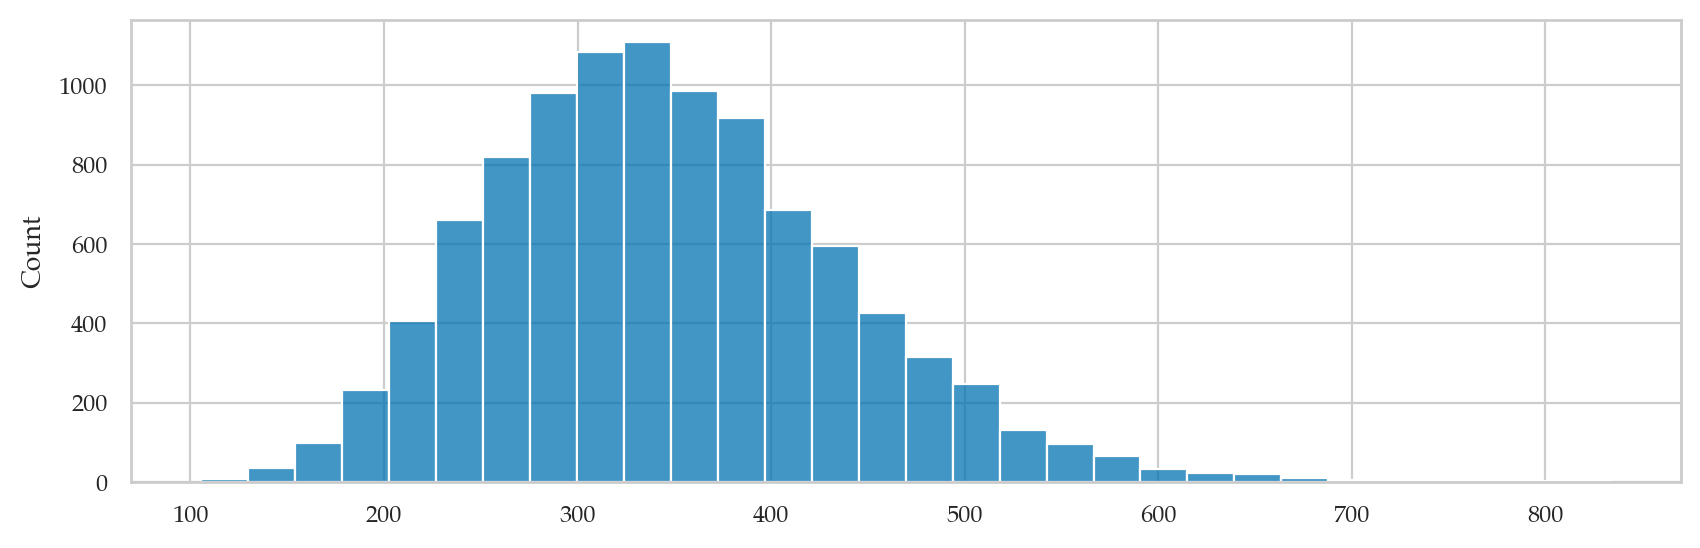

In [48]:
# Parametric boostrap 1: assume normal model for the population
avars_boot = gen_boot_dist(asample, estfunc=var)

n = asample.count()
abar = mean(asample)
astd = std(asample)
rvNS2 = norm(abar, astd)

from stats_helpers import gen_sampling_dist
avars_pboot1 = gen_sampling_dist(rvNS2, estfunc=var, n=n)

sns.histplot(avars_pboot1, bins=30)

[np.percentile(avars_pboot1,5),
 np.percentile(avars_pboot1,95)]

[212.76908831801552, 511.8854254249474]

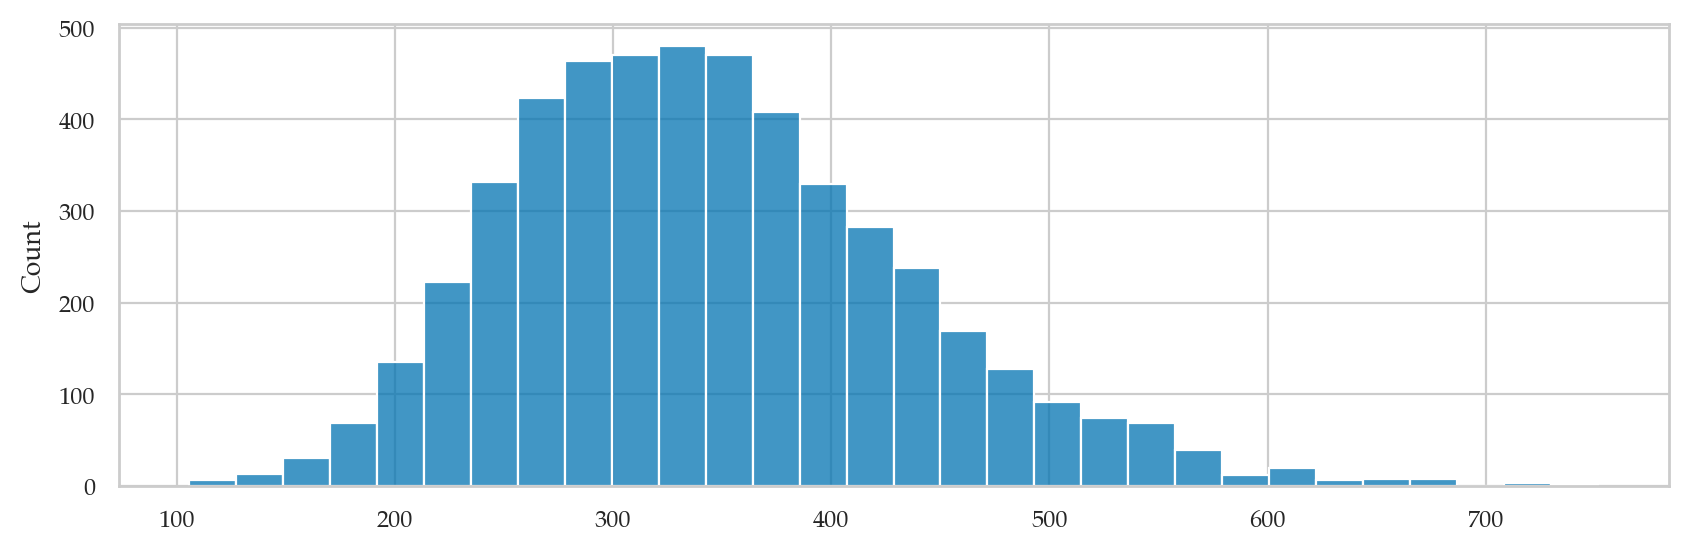

In [49]:
# Parametric boostrap 2: direct modelling of var using scaled chi-square model
# This is a random idea based on Example 4 in cut_material/discovering_estimator_formulas.tex
avars_boot = gen_boot_dist(asample, estfunc=var)

n = asample.count()
df = n-1
scale = var(asample) / (n-1)

from scipy.stats import chi2
rvS2 = chi2(df=df, scale=scale)

from stats_helpers import gen_sampling_dist
avars_pboot2 = rvS2.rvs(5000)

sns.histplot(avars_pboot2, bins=30)

[np.percentile(avars_pboot2,5),
 np.percentile(avars_pboot2,95)]

In [50]:
# Basic bootstrap (a.k.a. reversed)
from scipy.stats import bootstrap

np.random.seed(53)
res = bootstrap((asample,), statistic=var,
                confidence_level=0.9, n_resamples=5000,
                vectorized=False, method="basic")

# sns.histplot(res.bootstrap_distribution, bins=30)

[res.confidence_interval.low,
 res.confidence_interval.high]

[211.122988505747, 495.557011494253]

In [51]:
# BCa = Bias-Corrected accelerated
from scipy.stats import bootstrap

np.random.seed(53)
res = bootstrap((asample,), statistic=var,
                confidence_level=0.9, n_resamples=5000,
                vectorized=False, method="bca")

# sns.histplot(res.bootstrap_distribution, bins=30)

[res.confidence_interval.low,
 res.confidence_interval.high]

[231.29845557680545, 541.4179333052508]

This interval is very close to the analytical approximation we obtained
in terms of the chi-square reference distribution $[235.8, 566.6]$.

### Evaluation of confidence interval methods

Rows:
- uniform
- norm
- skewed ?
- long tailed (exp)
- bimodal

Cols:
- analytical approx
- percentile bootstrap
- basic bootstrap
- BCa



In [52]:
from scipy.stats import uniform, norm, lognorm, expon
from stats_helpers import mixnorms

# different populations to use for simulation
POPULATIONS = {      
    "U": uniform(),
    "Z": norm(),
    "S": lognorm(0.3),
    "E": expon(loc=0, scale=1/5),
    "B": mixnorms(locs=[3,6.2], scales=[1,1], weights=[0.4,0.6]),
}

METHODS = [
    "a",           # analytical approximation
    "percentile",  # percentile bootstrap
    "bca",         # bias-corrected accelerated bootstrap
]

#### Coverage probabilities for population mean

In [53]:
from stats_helpers import simulate_ci_props
restults_mean = simulate_ci_props(POPULATIONS, methods=METHODS,
                                  ns=[20,40], param="mean",
                                  alpha=0.1, N=1000, seed=42)
restults_mean

loaded cached results from  simdata/simulate_ci_props_mean__ns_20_40__alpha_0.1__seed_42.csv


property           wbar                         cov                  
method                a percentile       bca      a percentile    bca
population n                                                         
U          20  0.220841   0.204631  0.205162  0.893      0.867  0.885
           40  0.153680   0.148055  0.148230  0.900      0.888  0.896
Z          20  0.770453   0.714570  0.716912  0.884      0.851  0.855
           40  0.526034   0.506770  0.507304  0.905      0.899  0.887
S          20  0.243806   0.225700  0.229662  0.886      0.868  0.859
           40  0.169247   0.163001  0.164269  0.902      0.890  0.892
E          20  0.148030   0.136761  0.144141  0.874      0.849  0.858
           40  0.104478   0.100534  0.103630  0.877      0.866  0.862
B          20  1.419609   1.316295  1.320754  0.902      0.884  0.903
           40  0.983444   0.947381  0.948994  0.908      0.902  0.905

In [54]:
# print(restults_mean.to_latex(float_format="{:0.3f}".format))

#### Coverage probabilities for population variance


In [55]:
from stats_helpers import simulate_ci_props
restults_var = simulate_ci_props(POPULATIONS, methods=METHODS,
                                 ns=[20,40], param="var",
                                 alpha=0.1, N=1000, seed=43)
restults_var

loaded cached results from  simdata/simulate_ci_props_var__ns_20_40__alpha_0.1__seed_43.csv


property           wbar                         cov                  
method                a percentile       bca      a percentile    bca
population n                                                         
U          20  0.103879   0.056794  0.058629  0.983      0.855  0.857
           40  0.066634   0.039478  0.040195  0.993      0.884  0.889
Z          20  1.270557   0.938189  1.052797  0.898      0.825  0.840
           40  0.805057   0.696148  0.757683  0.893      0.845  0.865
S          20  0.128223   0.106803  0.122465  0.795      0.730  0.757
           40  0.084739   0.087967  0.100327  0.804      0.828  0.826
E          20  0.050138   0.054894  0.064792  0.625      0.661  0.711
           40  0.032610   0.045849  0.054231  0.640      0.756  0.804
B          20  4.332483   2.601501  2.774900  0.961      0.846  0.861
           40  2.824281   1.862927  1.947506  0.976      0.893  0.872

In [56]:
# print(restults_var.to_latex(float_format="{:0.3f}".format))